# STAT 5650 HW 3
### Seth Beckett

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, GridSearchCV, cross_val_predict, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.feature_selection import SequentialFeatureSelector

plt.style.use("ggplot")

## Problem 1
First I'll load and transform the nest data, as we did in the last homework.

In [2]:
nests = pd.read_csv("../data/Nest.csv")

In [3]:
nests_numerical = nests.drop(columns=["Nest", "Species", "StandType"])
log_X_nests = pd.DataFrame()

for col in nests_numerical.columns:
 log_X_nests[col] = np.log(nests_numerical[col] + 1)

log_X_nests["StandType"] = nests["StandType"]
y_nests = nests["Nest"]

### 1a. Combined Species KNN Performance

In [4]:
# use GridSearchCV to find the model with the best f1 score amongst the varying parameters
cv = KFold(10)
knn = KNeighborsClassifier()
params = {"n_neighbors": [i for i in range(3, 22, 2)]}
clf_f1 = GridSearchCV(knn, param_grid=params, scoring="f1", n_jobs=-1, cv=cv)

In [5]:
clf_f1.fit(log_X_nests, y_nests)
clf_f1.best_params_

{'n_neighbors': 3}

In [6]:
clf_f1.best_score_

0.8535266012759617

In [7]:
pd.DataFrame(clf_f1.cv_results_)[["param_n_neighbors", "mean_test_score", "rank_test_score"]]

,param_n_neighbors,mean_test_score,rank_test_score
0,3,0.853527,1
1,5,0.842503,3
2,7,0.833603,5
3,9,0.823309,6
4,11,0.843178,2
5,13,0.834957,4
6,15,0.812544,7
7,17,0.791189,10
8,19,0.796045,8
9,21,0.792878,9


From this we can see that when we use f1 score to rank our classifiers with different numbers of n-neighbors, the classifier with n=3 has the highest f1 score. Next we'll do the same thing, but using accuracy as our scorer, since that's the main metric we used for LDA and QDA.

In [8]:
clf_acc = GridSearchCV(knn, param_grid=params, scoring="accuracy", n_jobs=-1, cv=cv)
clf_acc.fit(log_X_nests, y_nests)
clf_acc.best_params_

{'n_neighbors': 3}

In [9]:
# accuracy of best fit model
clf_acc.best_score_

0.8597402597402597

In [10]:
pd.DataFrame(clf_acc.cv_results_)[["param_n_neighbors", "mean_test_score", "rank_test_score"]]

,param_n_neighbors,mean_test_score,rank_test_score
0,3,0.859740,1
1,5,0.845887,3
2,7,0.840909,4
3,9,0.831385,6
4,11,0.850216,2
5,13,0.840693,5
6,15,0.812554,7
7,17,0.798052,9
8,19,0.798701,8
9,21,0.788961,10


As we can see from `clf_acc.best_score_`, using a KNN classifier with 3 neighbors is the best in regards to accuracy. The accuracy of the cross-validated (10-fold) model fit using 3 neighbors is 85.97%. The last homework yielded results of 78.4% and 80.75% for LDA and QDA, respectively. KNN gives a clear boost in accuracy for this dataset. Below is the confusion matrix for the fitted KNN classifier.

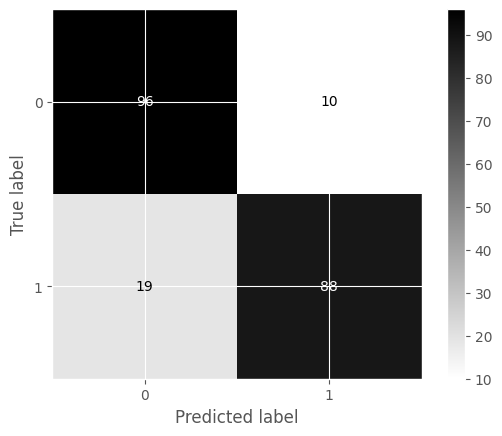

In [11]:
y_pred_nests = cross_val_predict(KNeighborsClassifier(n_neighbors=3), log_X_nests, y_nests)
ConfusionMatrixDisplay.from_predictions(y_nests, y_pred_nests, cmap="binary")

### 1b.

In [12]:
# creating species specific data
nests_w_log_data = log_X_nests
nests_w_log_data["Nest"] = y_nests
nests_w_log_data["Species"] = nests["Species"]

chickadee = nests_w_log_data.loc[(nests_w_log_data.Species == "Chickadee") 
                                 | (nests_w_log_data.Species == "Non-nest")]

sapsucker = nests_w_log_data.loc[(nests_w_log_data.Species == "Sapsucker") 
                                 | (nests_w_log_data.Species == "Non-nest")]

flicker = nests_w_log_data.loc[(nests_w_log_data.Species == "Flicker") 
                               | (nests_w_log_data.Species == "Non-nest")]

X_chickadee = chickadee.drop(columns=["Nest", "Species"])
y_chickadee = chickadee["Nest"]

X_sapsucker = sapsucker.drop(columns=["Nest", "Species"])
y_sapsucker = sapsucker["Nest"]

X_flicker = flicker.drop(columns=["Nest", "Species"])
y_flicker = flicker["Nest"]

In [13]:
# finding optimal k for each species
clf_acc.fit(X_chickadee, y_chickadee)
display(clf_acc.best_params_)

clf_acc.fit(X_sapsucker, y_sapsucker)
display(clf_acc.best_params_)

clf_acc.fit(X_flicker, y_flicker)
display(clf_acc.best_params_)

{'n_neighbors': 3}

{'n_neighbors': 5}

{'n_neighbors': 3}

One thing that is important to note here is that we will be using a KNN classifier with 5 neighbors for the sapsuckers, since our grid search found that to yield the highest accuracy. The other two species of birds will still use a model fit with 3 neighbors, since that gave the highest accuracy for their species.

Text(0.5, 1.0, 'Chickadee KNN(3) Confusion Matrix Normalized')

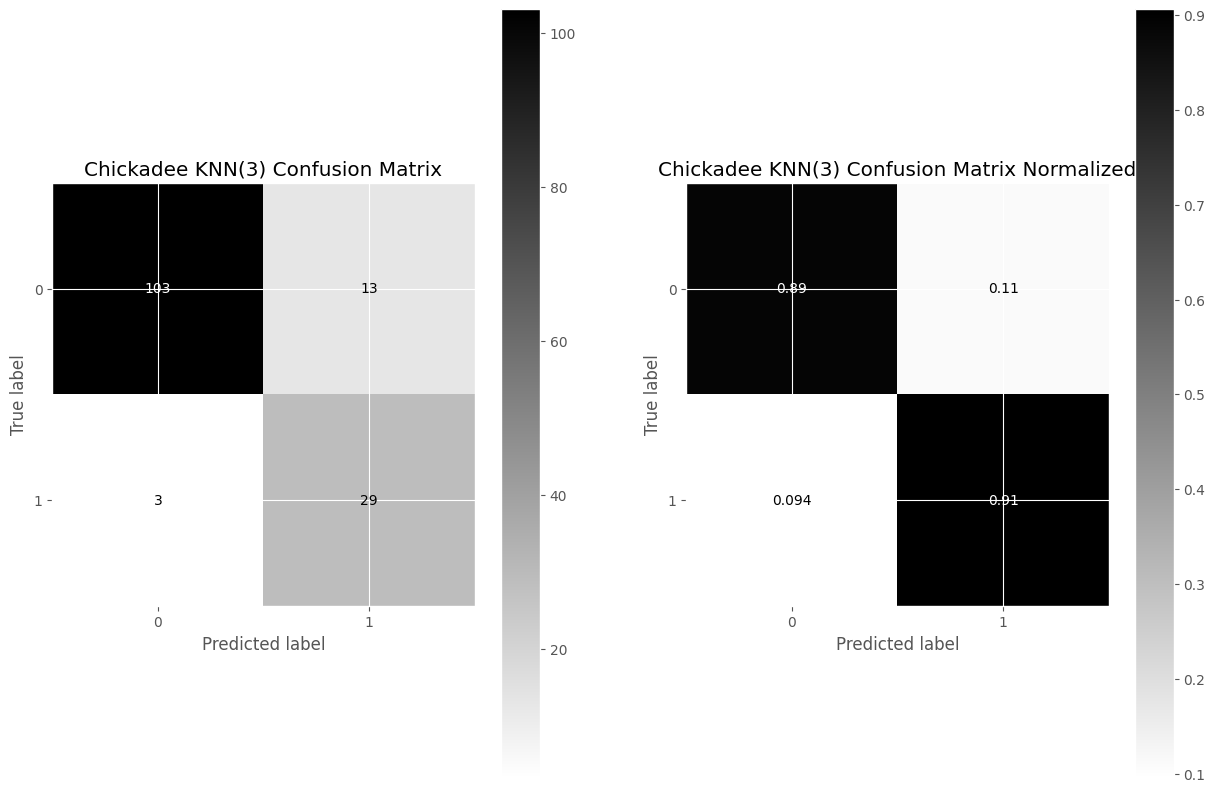

In [14]:
# chickadee accuracy and confusion matrix
y_pred_chickadee = cross_val_predict(KNeighborsClassifier(3), X_chickadee, y_chickadee, cv=cv)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,10))

ConfusionMatrixDisplay.from_predictions(y_pred_chickadee, y_chickadee, cmap="binary", ax=axs[0])
axs[0].set_title("Chickadee KNN(3) Confusion Matrix")

ConfusionMatrixDisplay.from_predictions(y_pred_chickadee, y_chickadee, 
                                        cmap="binary", normalize='true', ax=axs[1])
axs[1].set_title("Chickadee KNN(3) Confusion Matrix Normalized")

In [15]:
chic_acc = cross_validate(KNeighborsClassifier(3), X_chickadee, y_chickadee, scoring="accuracy", cv=cv)["test_score"].mean()
print(f"Accuracy of KNN(3) for Chickadee: {round(chic_acc, 4)}")

Accuracy of KNN(3) for Chickadee: 0.8924


Text(0.5, 1.0, 'Sapsucker KNN(5) Confusion Matrix Normalized')

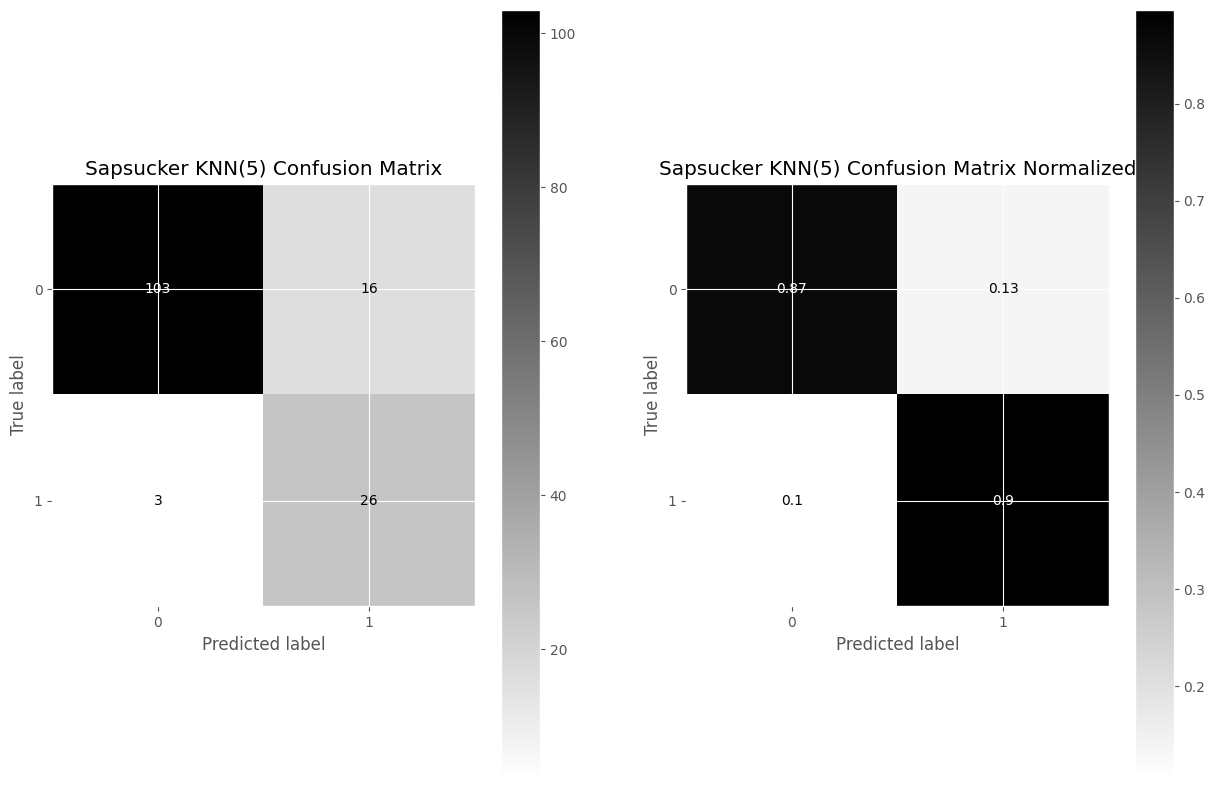

In [16]:
# sapsucker accuracy and confusion matrix
y_pred_sapsucker = cross_val_predict(KNeighborsClassifier(5), X_sapsucker, y_sapsucker, cv=cv)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,10))

ConfusionMatrixDisplay.from_predictions(y_pred_sapsucker, y_sapsucker, 
                                        cmap="binary", ax=axs[0])
axs[0].set_title("Sapsucker KNN(5) Confusion Matrix")

ConfusionMatrixDisplay.from_predictions(y_pred_sapsucker, y_sapsucker, 
                                        cmap="binary", normalize='true', ax=axs[1])
axs[1].set_title("Sapsucker KNN(5) Confusion Matrix Normalized")

In [17]:
sap_acc = cross_validate(KNeighborsClassifier(5), X_sapsucker, y_sapsucker, 
                         scoring="accuracy", cv=cv)["test_score"].mean()
print(f"Accuracy of KNN(5) for Sapsucker: {round(sap_acc, 4)}")

Accuracy of KNN(5) for Sapsucker: 0.871


Text(0.5, 1.0, 'Flicker KNN(3) Confusion Matrix Normalized')

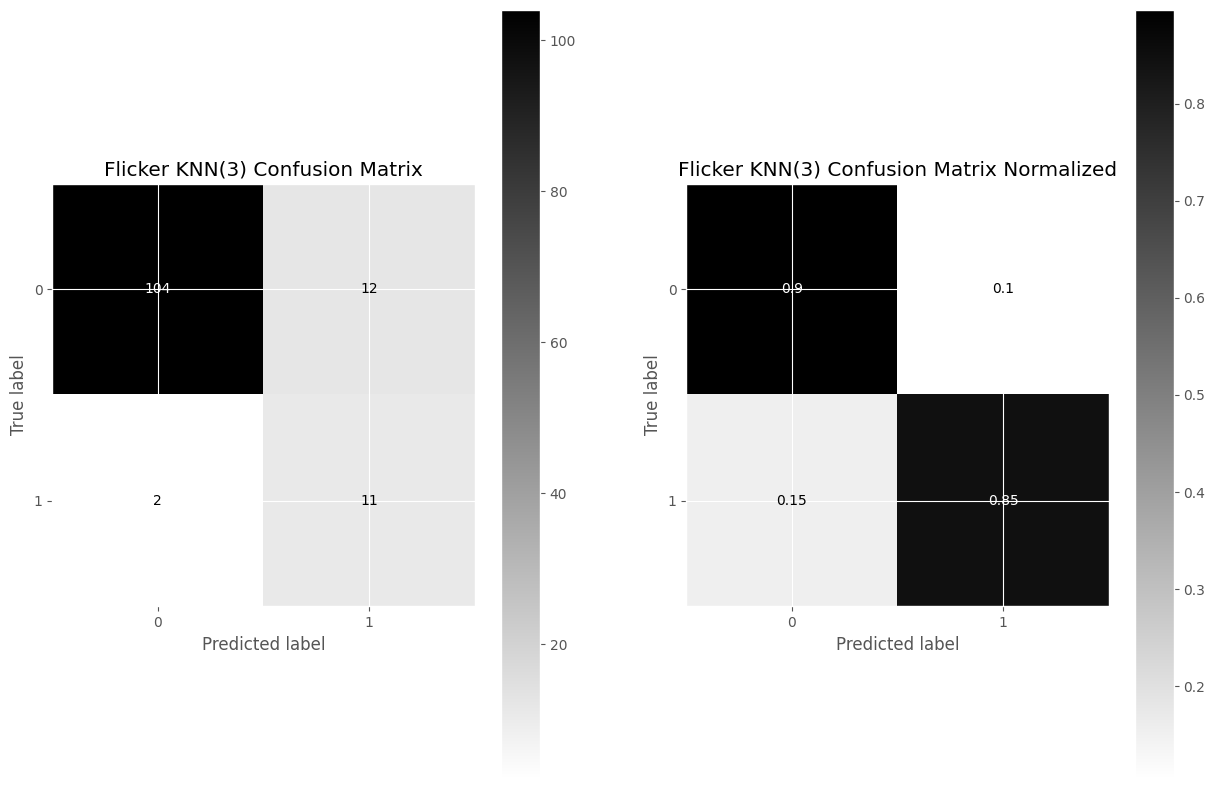

In [18]:
# flicker accuracy and confusion matrix
y_pred_flicker = cross_val_predict(KNeighborsClassifier(3), X_flicker, y_flicker, cv=cv)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,10))

ConfusionMatrixDisplay.from_predictions(y_pred_flicker, y_flicker, cmap="binary", ax=axs[0])
axs[0].set_title("Flicker KNN(3) Confusion Matrix")

ConfusionMatrixDisplay.from_predictions(y_pred_flicker, y_flicker, 
                                        cmap="binary", normalize='true', ax=axs[1])
axs[1].set_title("Flicker KNN(3) Confusion Matrix Normalized")

In [19]:
flic_acc = cross_validate(KNeighborsClassifier(3), X_flicker, y_flicker, 
                          scoring="accuracy", cv=cv)["test_score"].mean()
print(f"Accuracy of KNN(3) for Flicker: {round(flic_acc, 4)}")

Accuracy of KNN(3) for Flicker: 0.8923


From all of these analyses, we get accuracies of 89.24%, 87.1%, and 89.24% for the chickadee, sapsucker, and flicker models respectively. For brevity I will just list the best of the accuracies between LDA and QDA for each species from last time: chickadee with 80.4% accuracy, sapsucker with 81.08% accuracy, and flicker with 89.15% accuracy. Thus we see that by using a semi-optimized KNN classifier, we get a lot better accuracy than LDA or QDA per species. The accuracies of the three species when using KNN classifiers are also a lot less spread than the LDA/QDA accuracies.

## 2

### 2a

In [20]:
log_X_nests.drop(columns=["Species", "Nest"], inplace=True)
log_reg = LogisticRegression(max_iter=1000)
y_pred = cross_val_predict(log_reg, log_X_nests, y_nests, cv=cv)

Text(0.5, 1.0, 'Nests LogReg Confusion Matrix Normalized')

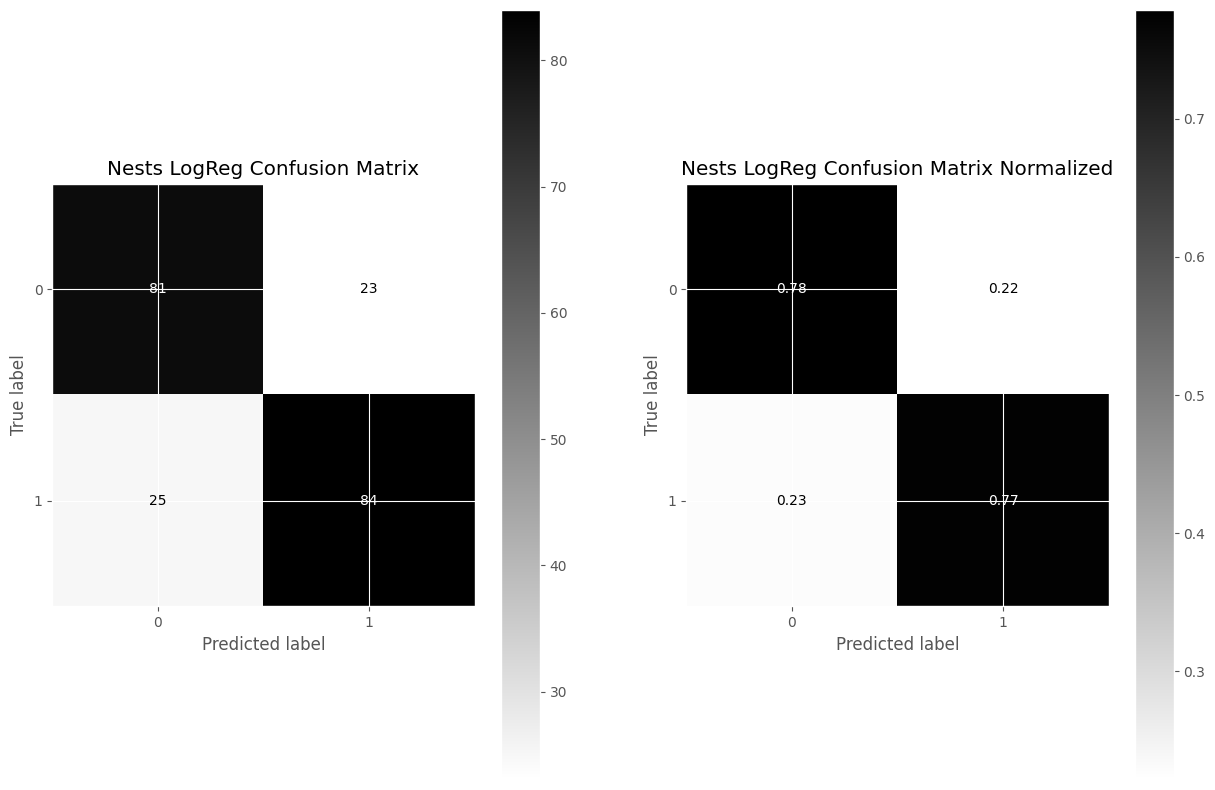

In [21]:
# logistic regression confusion matrix
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,10))

ConfusionMatrixDisplay.from_predictions(y_pred, y_nests, cmap="binary", ax=axs[0])
axs[0].set_title("Nests LogReg Confusion Matrix")

ConfusionMatrixDisplay.from_predictions(y_pred, y_nests, cmap="binary", normalize='true', ax=axs[1])
axs[1].set_title("Nests LogReg Confusion Matrix Normalized")

In [22]:
cross_validate(log_reg, log_X_nests, y_nests, cv=cv, scoring="accuracy")["test_score"].mean()

0.774891774891775

With an accuracy of 77.49%, we see that logistic regression using the combined species data performs worse than KNN, LDA, and QDA classifiers (86%, 79%, 81% accuracies). 

### 2b.

In [23]:
# use forward feature selection, stopping adding features when the accuracy improvement is less than 1%
sfs = SequentialFeatureSelector(log_reg, n_features_to_select="auto", tol=0.01, cv=cv, direction="forward", scoring="accuracy")
sfs.fit(log_X_nests, y_nests)
kept_cols = log_X_nests.columns[sfs.get_support()]
print(list(kept_cols))

['NumTree3to6in', 'NumDownSnags', 'NumConifer']


Text(0.5, 1.0, 'Nests LogReg Confusion Matrix Normalized')

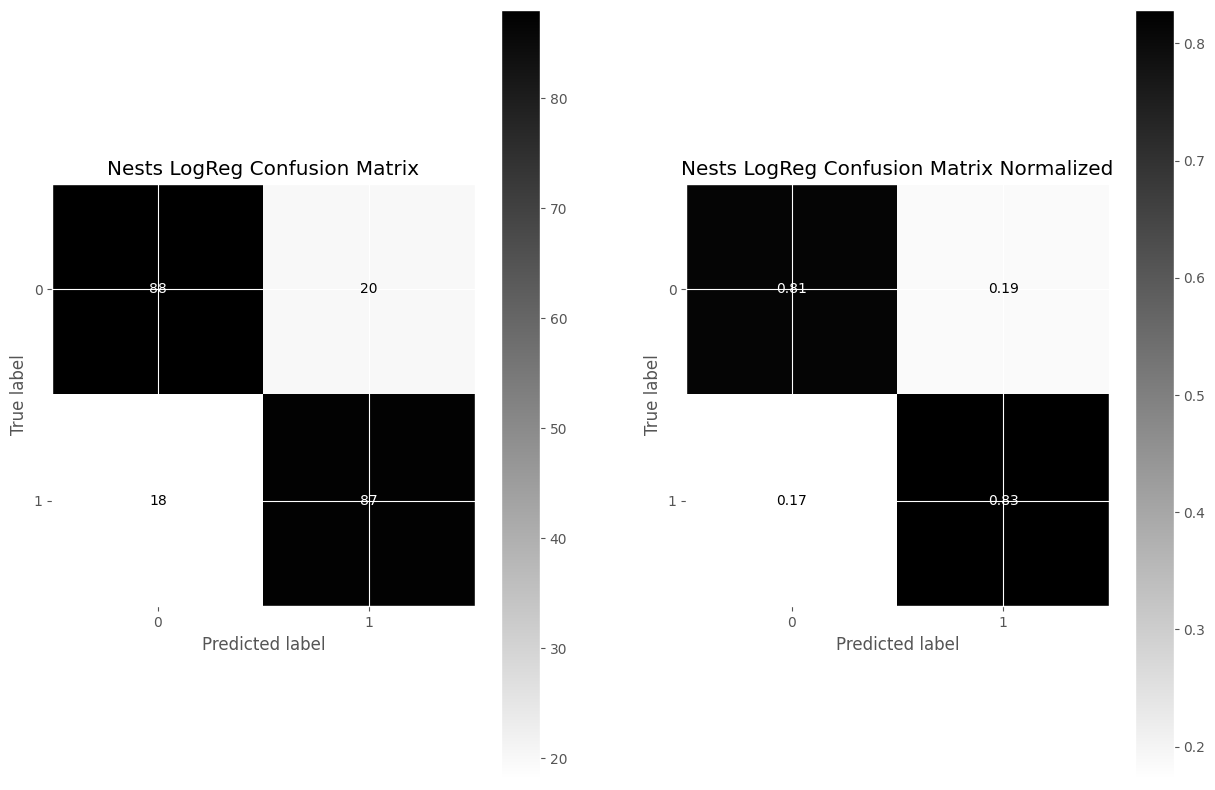

In [24]:
# logistic regression with feature selection confusion matrix
y_pred = cross_val_predict(log_reg, log_X_nests[kept_cols], y_nests, cv=cv)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,10))

ConfusionMatrixDisplay.from_predictions(y_pred, y_nests, cmap="binary", ax=axs[0])
axs[0].set_title("Nests LogReg Confusion Matrix")

ConfusionMatrixDisplay.from_predictions(y_pred, y_nests, cmap="binary", normalize='true', ax=axs[1])
axs[1].set_title("Nests LogReg Confusion Matrix Normalized")

In [25]:
# check accuracy of logistic regression model with only these features
cross_validate(log_reg, log_X_nests[kept_cols], y_nests, cv=cv, scoring="accuracy")["test_score"].mean()

0.8212121212121211

For feature selection on this logistic regression model, I used forward selection that stopped once a feature added less than 1% accuracy improvements. This left us with a model using only 3 variables: 'NumTree3to6in', 'NumDownSnags', and 'NumConifer'. when we check the cross-validated accuracy, we get 82%, which is about a 5% improvement from the logistic regression model with all of the features, and it makes this the second most accurate classifier among KNN, LDA, and QDA (trailing only behind KNN for the combined data).

### 2c.

Text(0.5, 1.0, 'Chickadee LogReg Confusion Matrix Normalized')

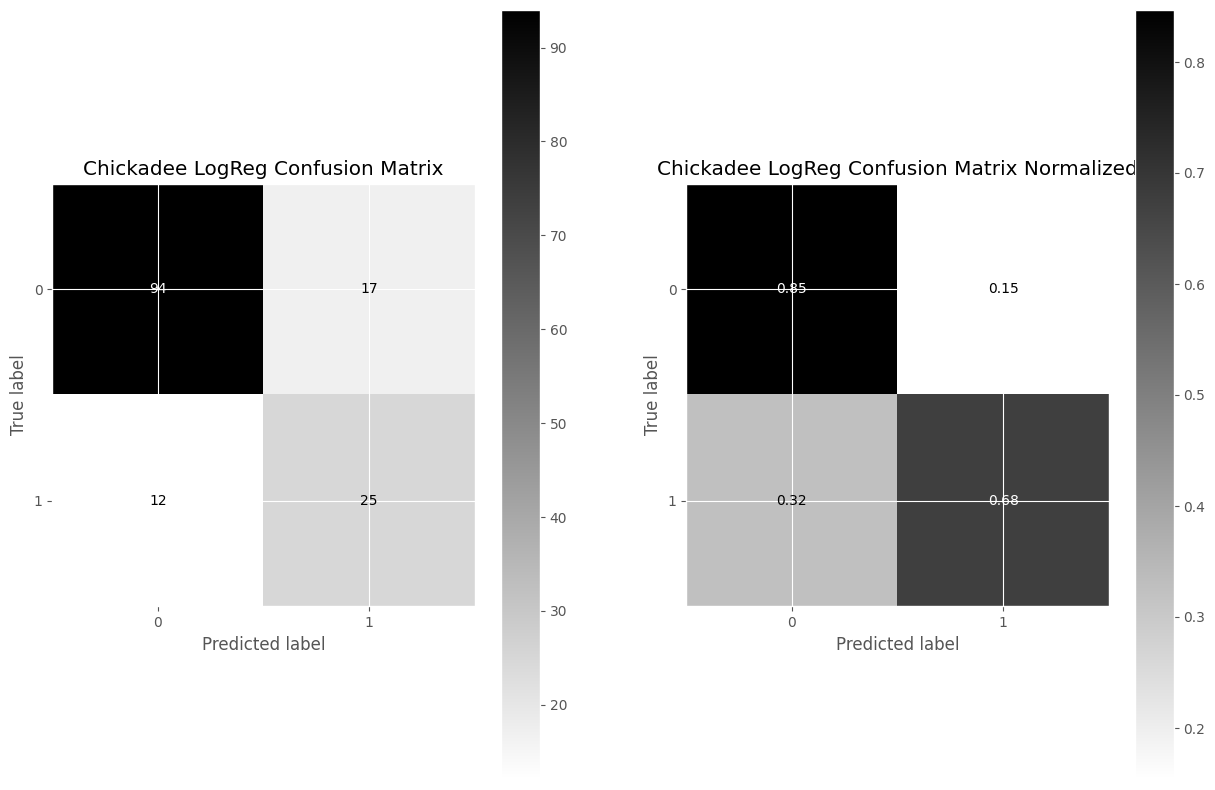

In [26]:
# chickadee logistic regression
y_pred_chickadee = cross_val_predict(log_reg, X_chickadee, y_chickadee, cv=cv)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,10))

ConfusionMatrixDisplay.from_predictions(y_pred_chickadee, y_chickadee, cmap="binary", ax=axs[0])
axs[0].set_title("Chickadee LogReg Confusion Matrix")

ConfusionMatrixDisplay.from_predictions(y_pred_chickadee, y_chickadee, cmap="binary", normalize='true', ax=axs[1])
axs[1].set_title("Chickadee LogReg Confusion Matrix Normalized")

In [27]:
# chickadee logreg accuracy
chic_acc = cross_validate(log_reg, X_chickadee, y_chickadee, scoring="accuracy", cv=cv)["test_score"].mean()
print(f"Accuracy of logistic regression for Chickadee: {round(chic_acc, 4)}")

Accuracy of logistic regression for Chickadee: 0.8043


Text(0.5, 1.0, 'Sapsucker LogReg Confusion Matrix Normalized')

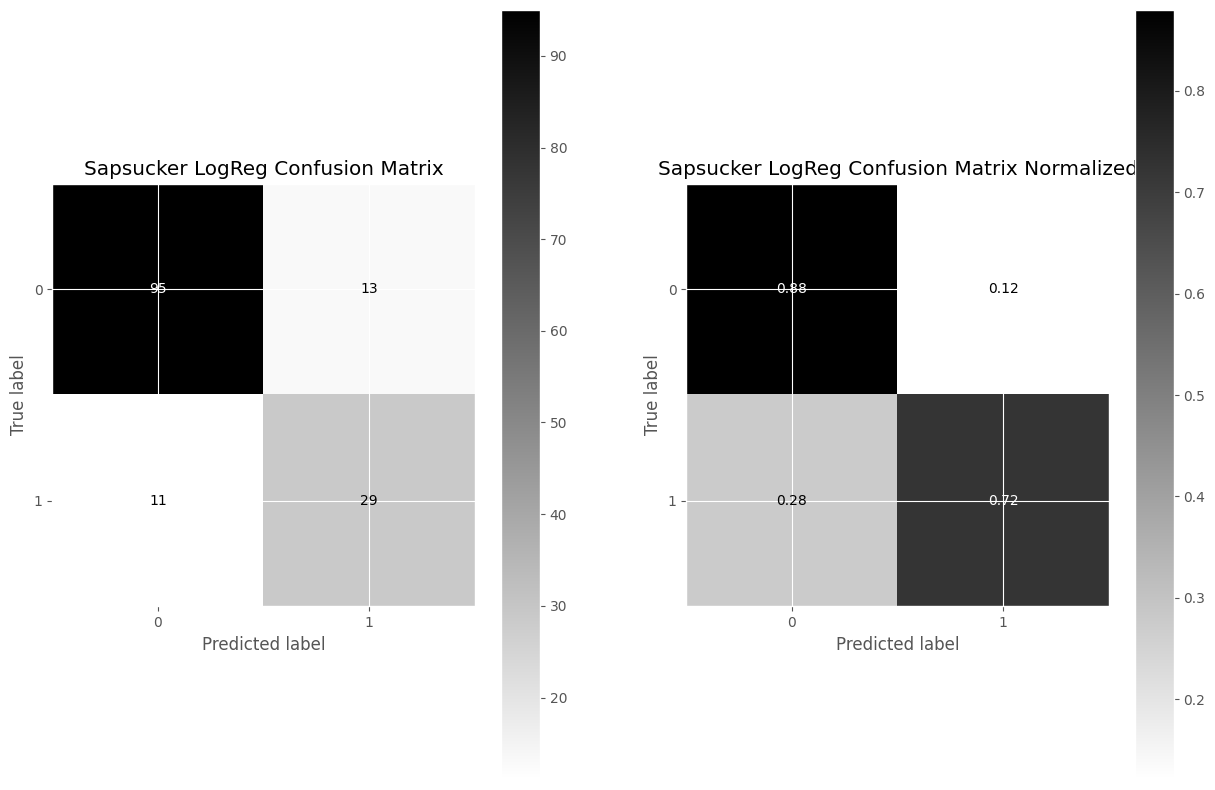

In [28]:
# sapsucker logistic regression
y_pred_sapsucker = cross_val_predict(log_reg, X_sapsucker, y_sapsucker, cv=cv)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,10))

ConfusionMatrixDisplay.from_predictions(y_pred_sapsucker, y_sapsucker, cmap="binary", ax=axs[0])
axs[0].set_title("Sapsucker LogReg Confusion Matrix")

ConfusionMatrixDisplay.from_predictions(y_pred_sapsucker, y_sapsucker, cmap="binary", normalize='true', ax=axs[1])
axs[1].set_title("Sapsucker LogReg Confusion Matrix Normalized")

In [29]:
# sapsucker logreg accuracy
sap_acc = cross_validate(log_reg, X_sapsucker, y_sapsucker, scoring="accuracy", cv=cv)["test_score"].mean()
print(f"Accuracy of logistic regression for Sapsucker: {round(sap_acc, 4)}")

Accuracy of logistic regression for Sapsucker: 0.84


Text(0.5, 1.0, 'Flicker LogReg Confusion Matrix Normalized')

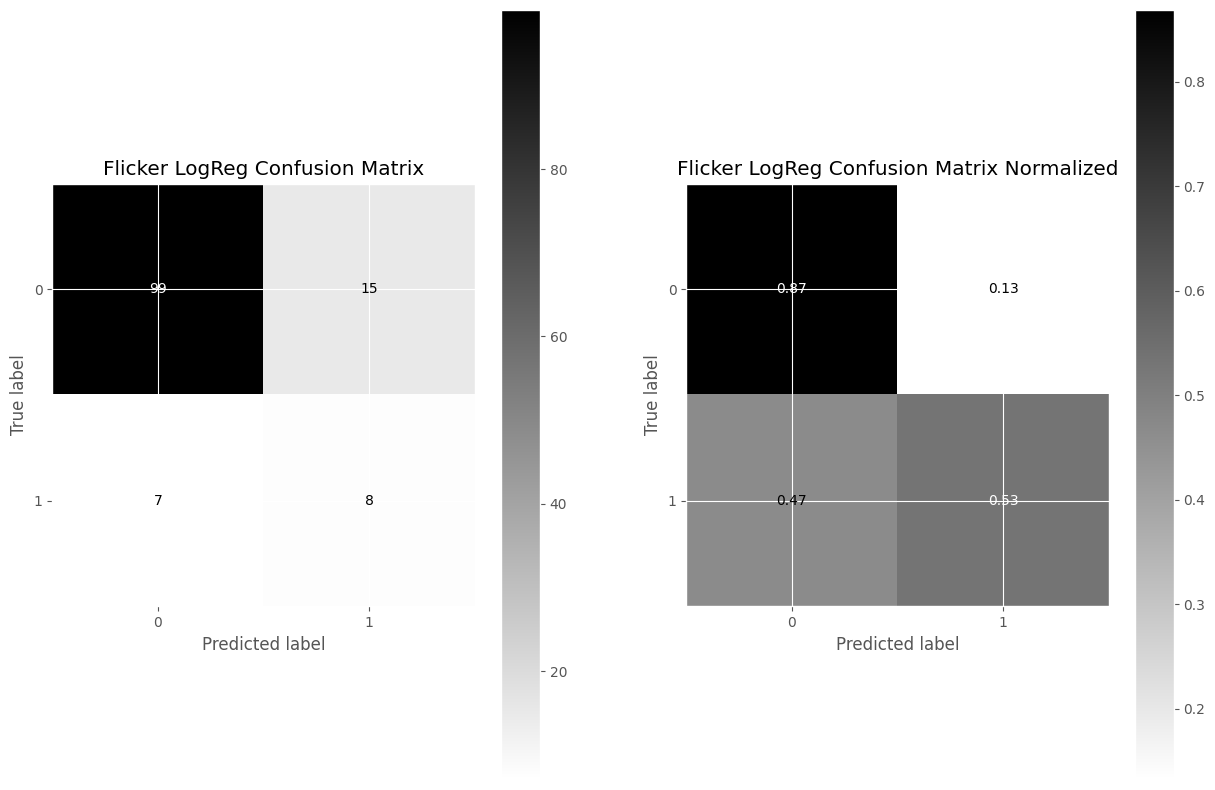

In [30]:
# flicker logistic regression
y_pred_flicker = cross_val_predict(log_reg, X_flicker, y_flicker, cv=cv)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,10))

ConfusionMatrixDisplay.from_predictions(y_pred_flicker, y_flicker, cmap="binary", ax=axs[0])
axs[0].set_title("Flicker LogReg Confusion Matrix")

ConfusionMatrixDisplay.from_predictions(y_pred_flicker, y_flicker, cmap="binary", normalize='true', ax=axs[1])
axs[1].set_title("Flicker LogReg Confusion Matrix Normalized")

In [31]:
# flicker logreg accuracy
flic_acc = cross_validate(log_reg, X_flicker, y_flicker, scoring="accuracy", cv=cv)["test_score"].mean()
print(f"Accuracy of logistic regression for Flicker: {round(flic_acc, 4)}")

Accuracy of logistic regression for Flicker: 0.8308


When each species is fitted with a logistic regression model without feature selection, we get accuracies of 80.43%, 84%, and 83.08% for chickadee, sapsucker, and flicker models, respectively. KNN accuracies were 89%, 87%, and 89%, so regular logistic regression does not match that accuracy. For the best of LDA/QDA, we get 80%, 81%, and 89% for the three species. So LDA/QDA is more of a toss up when comparing just chickadee models, slightly worse comparing sapsucker models, and LDA/QDA wins out by a decent margin for flicker accuracy. 

### 2d.

In [32]:
# chickadee forward variable selection logistic regression
sfs = SequentialFeatureSelector(log_reg, n_features_to_select="auto", tol=0.01, cv=cv, direction="forward")
sfs.fit(X_chickadee, y_chickadee)
kept_cols = X_chickadee.columns[sfs.get_support()]
print(list(kept_cols))

['NumTree3to6in', 'NumTree9to15in', 'NumConifer']


In [33]:
# chickadee variable selection accuracy
cross_validate(log_reg, X_chickadee[kept_cols], y_chickadee, cv=cv, scoring="accuracy")["test_score"].mean()

0.8176190476190476

In [34]:
# sapsucker forward variable selection logreg
sfs = SequentialFeatureSelector(log_reg, n_features_to_select="auto", tol=0.01, cv=cv, direction="forward")
sfs.fit(X_sapsucker, y_sapsucker)
kept_cols = X_sapsucker.columns[sfs.get_support()]
print(list(kept_cols))

['NumTreelt1in', 'NumTree3to6in']


In [35]:
# sapsucker forward selected accuracy
cross_validate(log_reg, X_sapsucker[kept_cols], y_sapsucker, cv=cv, scoring="accuracy")["test_score"].mean()

0.8452380952380952

In [36]:
# flicker forward selection
sfs = SequentialFeatureSelector(log_reg, n_features_to_select="auto", tol=0.01, cv=cv, direction="forward")
sfs.fit(X_flicker, y_flicker)
kept_cols = X_flicker.columns[sfs.get_support()]
print(list(kept_cols))

['NumTree3to6in']


In [37]:
# flicker forward selected accuracy
cross_validate(log_reg, X_flicker[kept_cols], y_flicker, cv=cv, scoring="accuracy")["test_score"].mean()

0.860897435897436

These results are pretty sick, as the species accuracies all improved compared to no feature selection. They went from 80%, 84%, and 83% using no feature selection to 82%, 85%, and 86%. One interesting thing is that for the flicker model, only one variable was used, 'NumTree3to6in'. All three of these feature selected models still don't compare to the accuracy of KNN, but the logistic regression models with feature importance for chickadee and sapsucker both are better than the best LDA/QDA models (82% vs 80%, 85% vs 81%). I didn't include the confusion matrices for these because that would've taken up a ton more space and this is already pretty long haha.

## 3

In [38]:
diabetes = pd.read_csv("../data/Pima Diabetes 3.csv")

In [39]:
diabetes.head()

,NumPregnant,PlasmaGlucose,DiastolicBP,SkinFoldThick,SerumInsulin,BMI,DPF,Age,Diabetes
0,1,89,66,23,94,28.1,0.167,21,0
1,0,137,40,35,168,43.1,2.288,33,1
2,3,78,50,32,88,31.0,0.248,26,1
3,2,197,70,45,543,30.5,0.158,53,1
4,1,189,60,23,846,30.1,0.398,59,1


In [40]:
X_diabetes = diabetes.drop(columns="Diabetes")
y_diabetes = diabetes["Diabetes"]

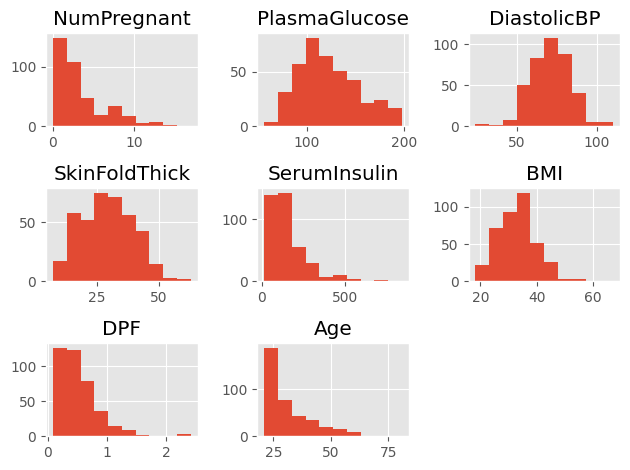

In [41]:
# check out distribution of data
X_diabetes.hist()
plt.tight_layout()

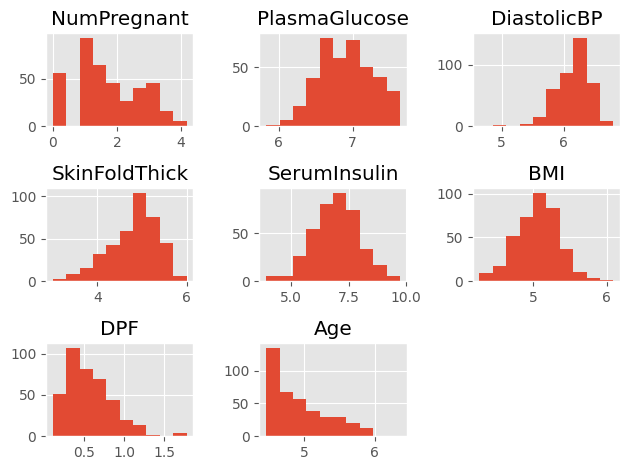

In [42]:
np.log2(X_diabetes + 1).hist()
plt.tight_layout()

The data are more normal, but still not all the way normal when log-transformed. Logistic regression doesn't require normality of data though, so we should be good to just use the original data and then look at variable selection. When comparing the cross-validated scores for the log-transformed vs regular data, we see that the regular data fit model scores higher in almost every metric (I deleted this code, it just added confusion to the feature selection code).

In [43]:
# vanilla logistic regression accuracy, precision, recall, and f1
diabetes_cv_scores = cross_validate(log_reg, X_diabetes, y_diabetes, cv=cv, scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])

print("Mean Cross-Validated Metrics")
for key in diabetes_cv_scores:
    print(key + ": " + str(diabetes_cv_scores[key].mean()))
    # print(diabetes_cv_scores[key])
    

Mean Cross-Validated Metrics
fit_time: 0.007133293151855469
score_time: 0.0021846771240234377
test_accuracy: 0.7829487179487179
test_precision: 0.7102380952380952
test_recall: 0.5905298867798867
test_f1: 0.6393283538711926
test_roc_auc: 0.8478380325951639


Text(0.5, 1.0, 'Diabetes Full Model Confusion Matrix Normalized')

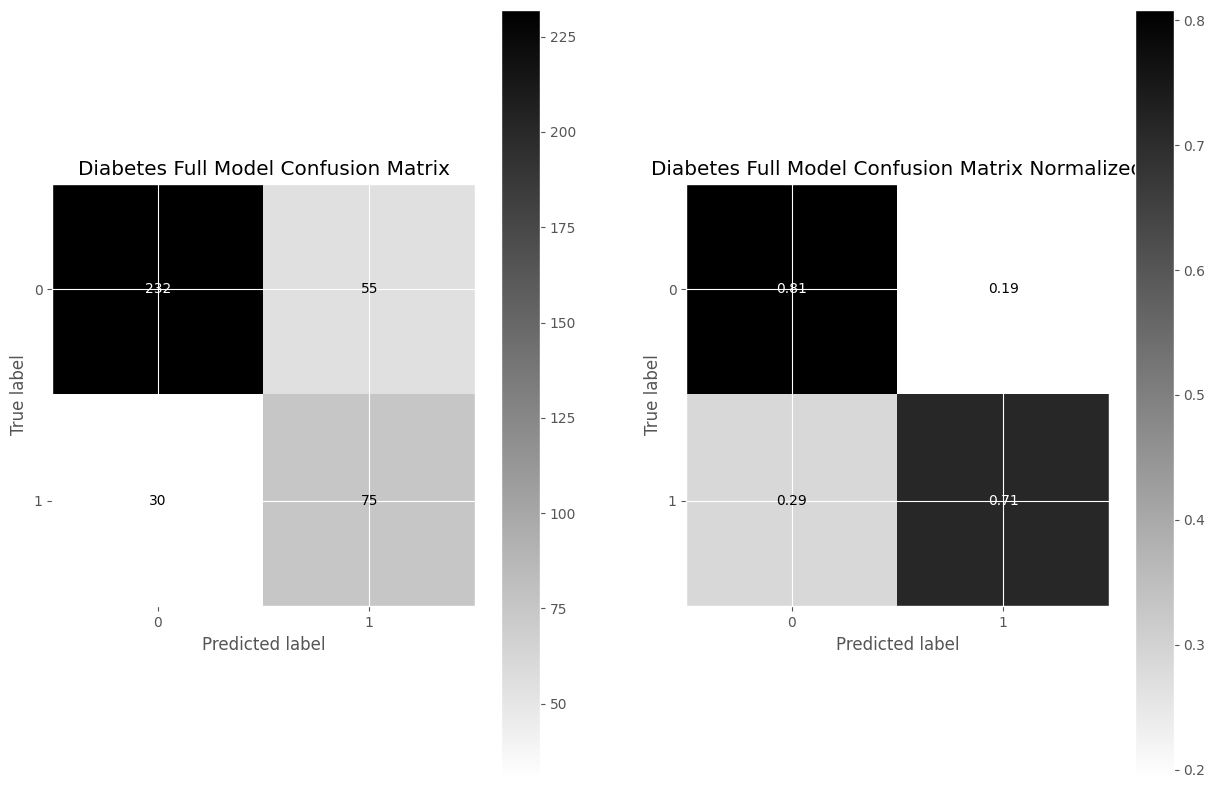

In [44]:
# full model accuracy and confusion matrix
y_pred_diabetes = cross_val_predict(log_reg, X_diabetes, y_diabetes, cv=cv)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,10))

ConfusionMatrixDisplay.from_predictions(y_pred_diabetes, y_diabetes, cmap="binary", ax=axs[0])
axs[0].set_title("Diabetes Full Model Confusion Matrix")

ConfusionMatrixDisplay.from_predictions(y_pred_diabetes, y_diabetes, cmap="binary", normalize='true', ax=axs[1])
axs[1].set_title("Diabetes Full Model Confusion Matrix Normalized")

In [45]:
# forward variable selection using logistic regression accuracy
sfs = SequentialFeatureSelector(log_reg, n_features_to_select="auto", tol=0.01, cv=cv, direction="forward")
sfs.fit(X_diabetes, y_diabetes)
kept_cols = X_diabetes.columns[sfs.get_support()]
print(list(kept_cols))

['PlasmaGlucose', 'SkinFoldThick']


In [46]:
# compare forward selected metrics
diabetes_cv_scores = cross_validate(log_reg, X_diabetes[kept_cols], y_diabetes, cv=cv, scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])

print("Forward Selected CV Metrics")
for key in diabetes_cv_scores:
    print(key + ": " + str(diabetes_cv_scores[key].mean()))

Forward Selected CV Metrics
fit_time: 0.002049851417541504
score_time: 0.0019529342651367187
test_accuracy: 0.7857051282051282
test_precision: 0.7321212121212122
test_recall: 0.587922077922078
test_f1: 0.6416966769140683
test_roc_auc: 0.8241082187815417


Text(0.5, 1.0, 'Diabetes Forward-Selected Confusion Matrix Normalized')

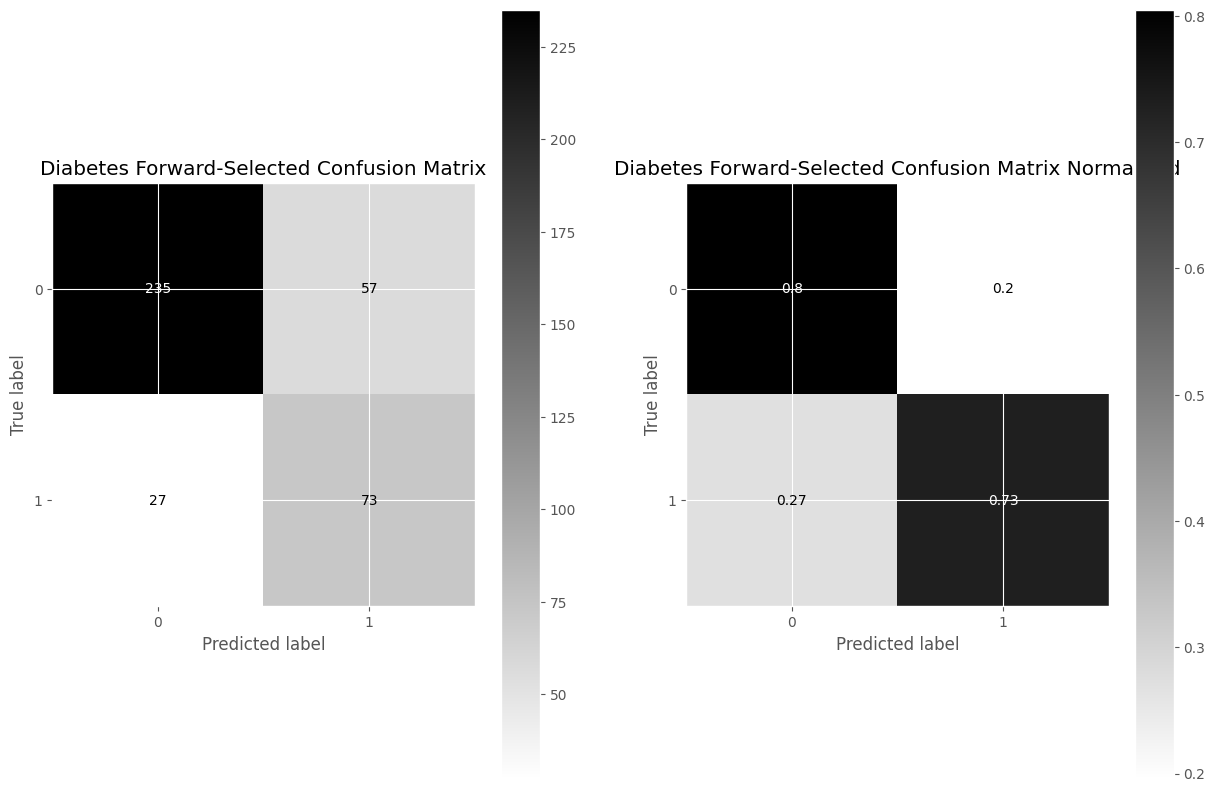

In [47]:
# forward selected model accuracy and confusion matrix
y_pred_diabetes = cross_val_predict(log_reg, X_diabetes[kept_cols], y_diabetes, cv=cv)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,10))

ConfusionMatrixDisplay.from_predictions(y_pred_diabetes, y_diabetes, cmap="binary", ax=axs[0])
axs[0].set_title("Diabetes Forward-Selected Confusion Matrix")

ConfusionMatrixDisplay.from_predictions(y_pred_diabetes, y_diabetes, cmap="binary", normalize='true', ax=axs[1])
axs[1].set_title("Diabetes Forward-Selected Confusion Matrix Normalized")

In [48]:
# try backward selection
sfs = SequentialFeatureSelector(log_reg, n_features_to_select="auto", tol=0.01, cv=cv, direction="backward")
sfs.fit(X_diabetes, y_diabetes)
kept_cols = X_diabetes.columns[sfs.get_support()]
print(list(kept_cols))

['NumPregnant', 'PlasmaGlucose', 'DiastolicBP', 'SkinFoldThick', 'SerumInsulin', 'DPF', 'Age']


In [49]:
# compare backward selected metrics
diabetes_cv_scores = cross_validate(log_reg, X_diabetes[kept_cols], y_diabetes, cv=cv, scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])

print("Backward Selected CV Metrics")
for key in diabetes_cv_scores:
    print(key + ": " + str(diabetes_cv_scores[key].mean()))

Backward Selected CV Metrics
fit_time: 0.005978536605834961
score_time: 0.002380633354187012
test_accuracy: 0.7905769230769231
test_precision: 0.7278860028860029
test_recall: 0.5837117049617049
test_f1: 0.6420056935817805
test_roc_auc: 0.84039278334649


Text(0.5, 1.0, 'Diabetes Backward-Selected Confusion Matrix Normalized')

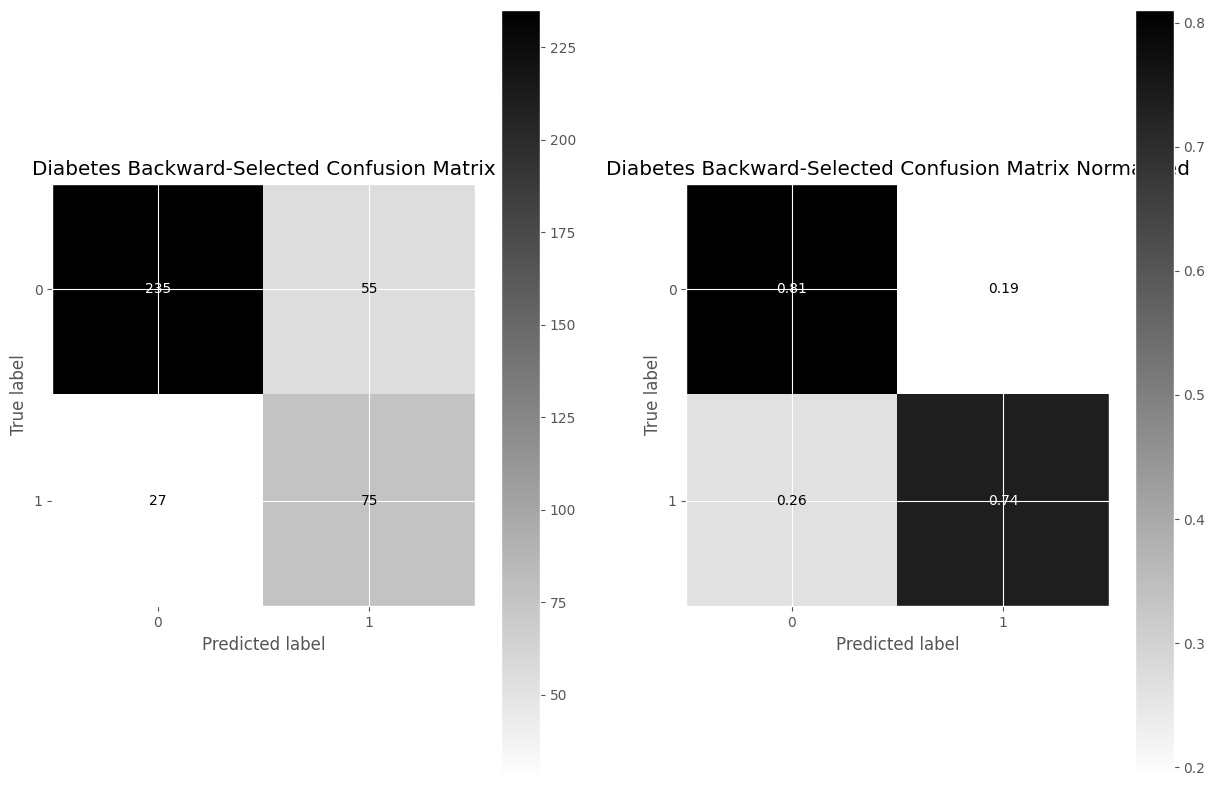

In [50]:
# backward selected model accuracy and confusion matrix
y_pred_diabetes = cross_val_predict(log_reg, X_diabetes[kept_cols], y_diabetes, cv=cv)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,10))

ConfusionMatrixDisplay.from_predictions(y_pred_diabetes, y_diabetes, cmap="binary", ax=axs[0])
axs[0].set_title("Diabetes Backward-Selected Confusion Matrix")

ConfusionMatrixDisplay.from_predictions(y_pred_diabetes, y_diabetes, cmap="binary", normalize='true', ax=axs[1])
axs[1].set_title("Diabetes Backward-Selected Confusion Matrix Normalized")

Similar to earlier, I used forward selection to test if there would be noticable improvements in the model for the diabetes data. This would stop adding variables to the model once the model with them added increased accuracy by less than one percent. I also included backward feature selection, where features were removed until the fitted model accuracy improved by less than one percent. 

Using backward selection only removed one feature, 'BMI'. With forward selection, only two features were selected: 'PlasmaGlucose' and 'SkinFoldThick'. Comparing accuracies of the regular, forward-selected, and backward-selected logistic regression models, we get 78.3%, 78.5%, and 79.1%. The forward-selected model had the highest precision score, and a higher recall score than the backward-selected model. Both selective models have an F1 score barely higher than the regular model.

What is most noticable is how close all of the scoring metrics are among the three logistic regression models, but the forward selected one only has two variables. Almost no predictive power is lost by only using those two variables. Variable selection isn't necessary for this problem, but if I was trying to explain the most important factors in predicting diabetes to someone, I would definitely focus on plasma glucose and skin fold thickness.